## **Análisis exploratorio:**




📊 ESTADÍSTICOS DESCRIPTIVOS (CONSUMO):
                               fecha        regular       superior  \
count                            304     304.000000     304.000000   
mean   2012-08-16 11:17:22.105263104  403342.710353  473481.124061   
min              2000-01-01 00:00:00  160741.900000  300242.781667   
25%              2006-04-23 12:00:00  216389.010000  384867.278333   
50%              2012-08-16 12:00:00  290212.070000  424351.605000   
75%              2018-12-08 18:00:00  567883.585000  574714.727500   
max              2025-05-01 00:00:00  942394.340000  790948.040000   
std                              NaN  223561.455551  116279.496318   

             diesel            glp  
count  3.040000e+02     304.000000  
mean   8.782422e+05  322090.176211  
min    5.076627e+05  167818.137897  
25%    7.008934e+05  226969.995774  
50%    8.058445e+05  268254.608333  
75%    1.057357e+06  407378.575000  
max    1.463008e+06  600453.870000  
std    2.298339e+05  118362.42840

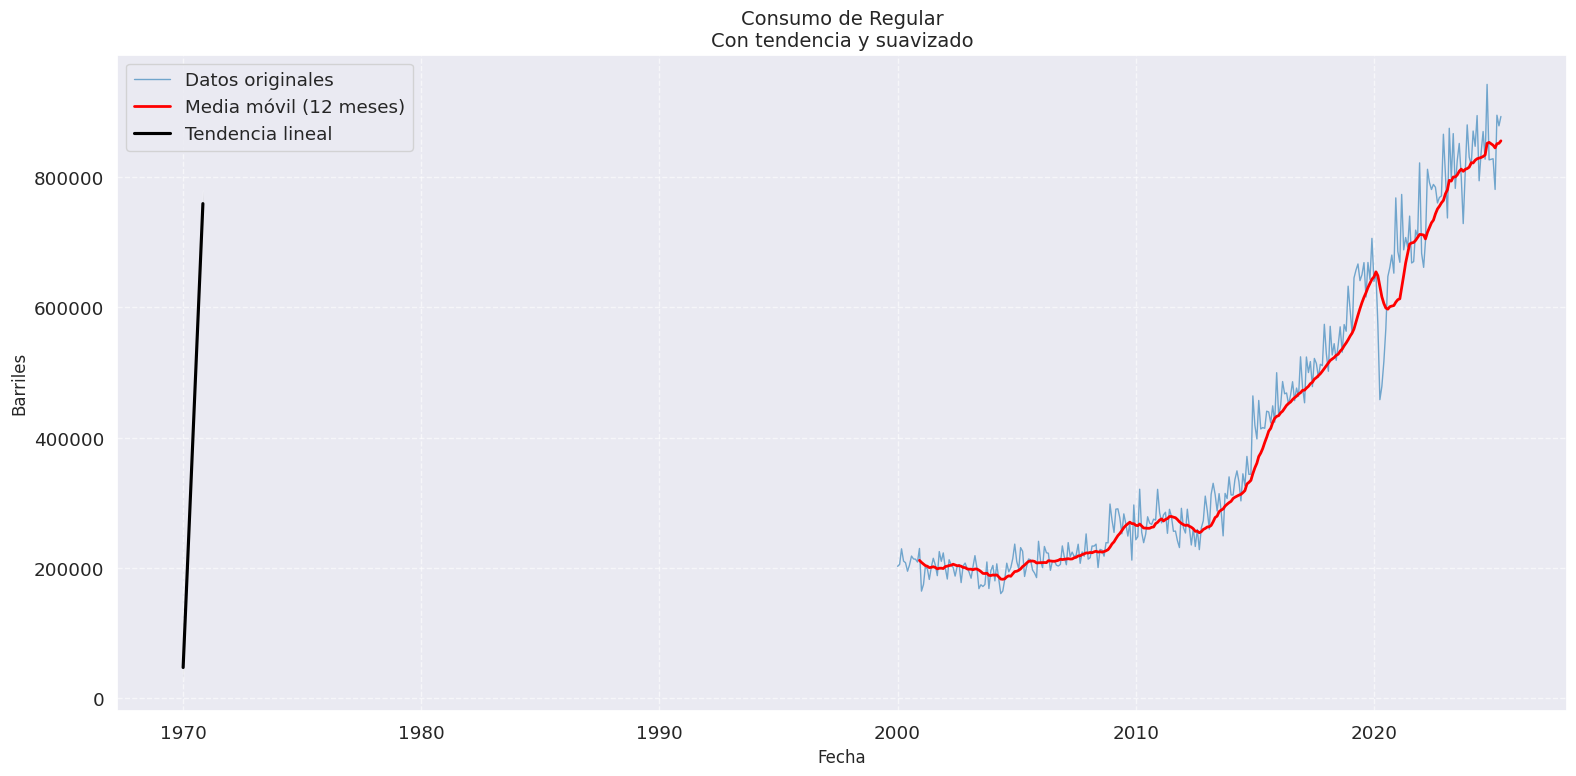

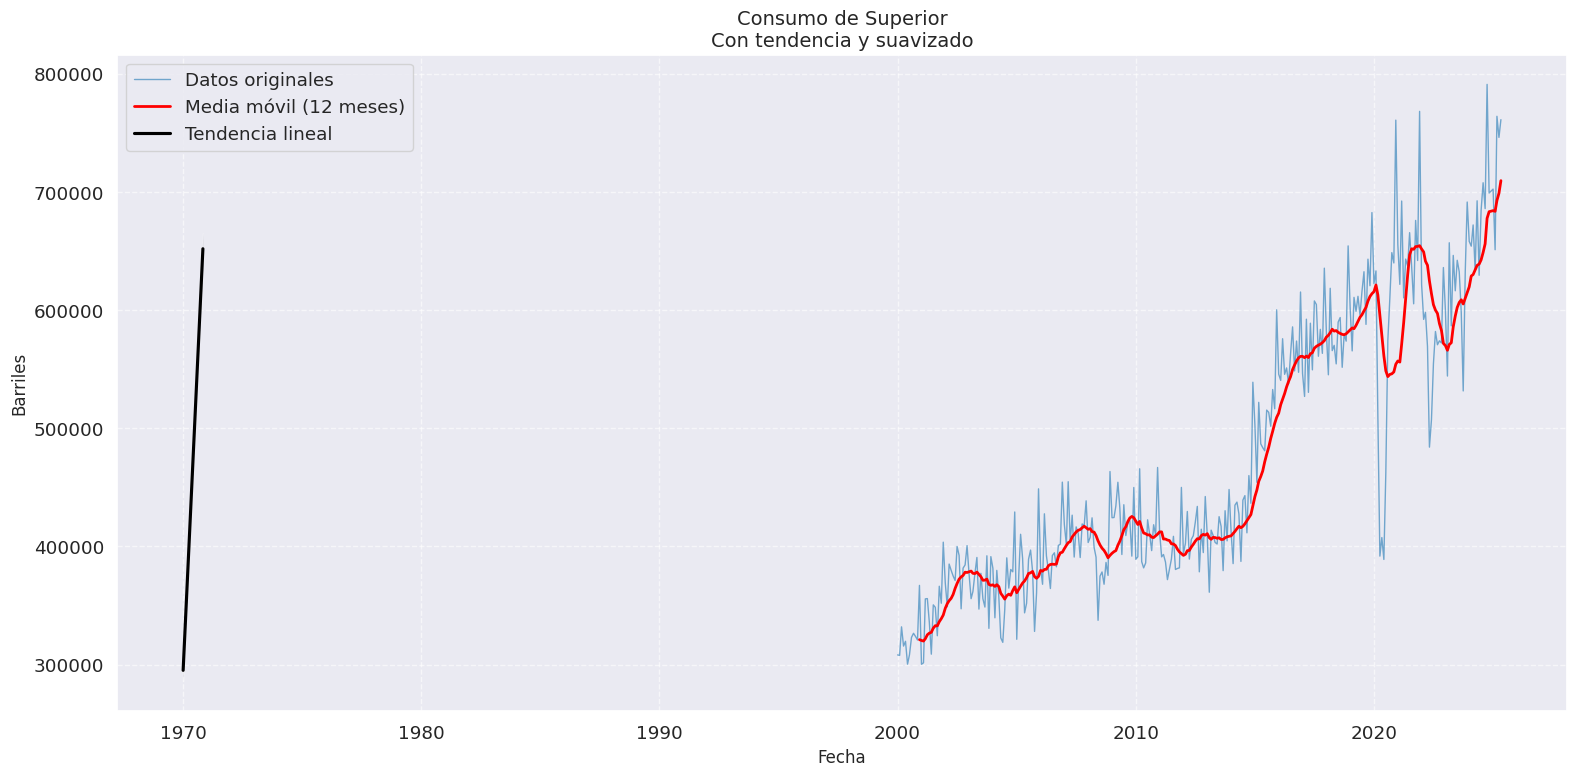

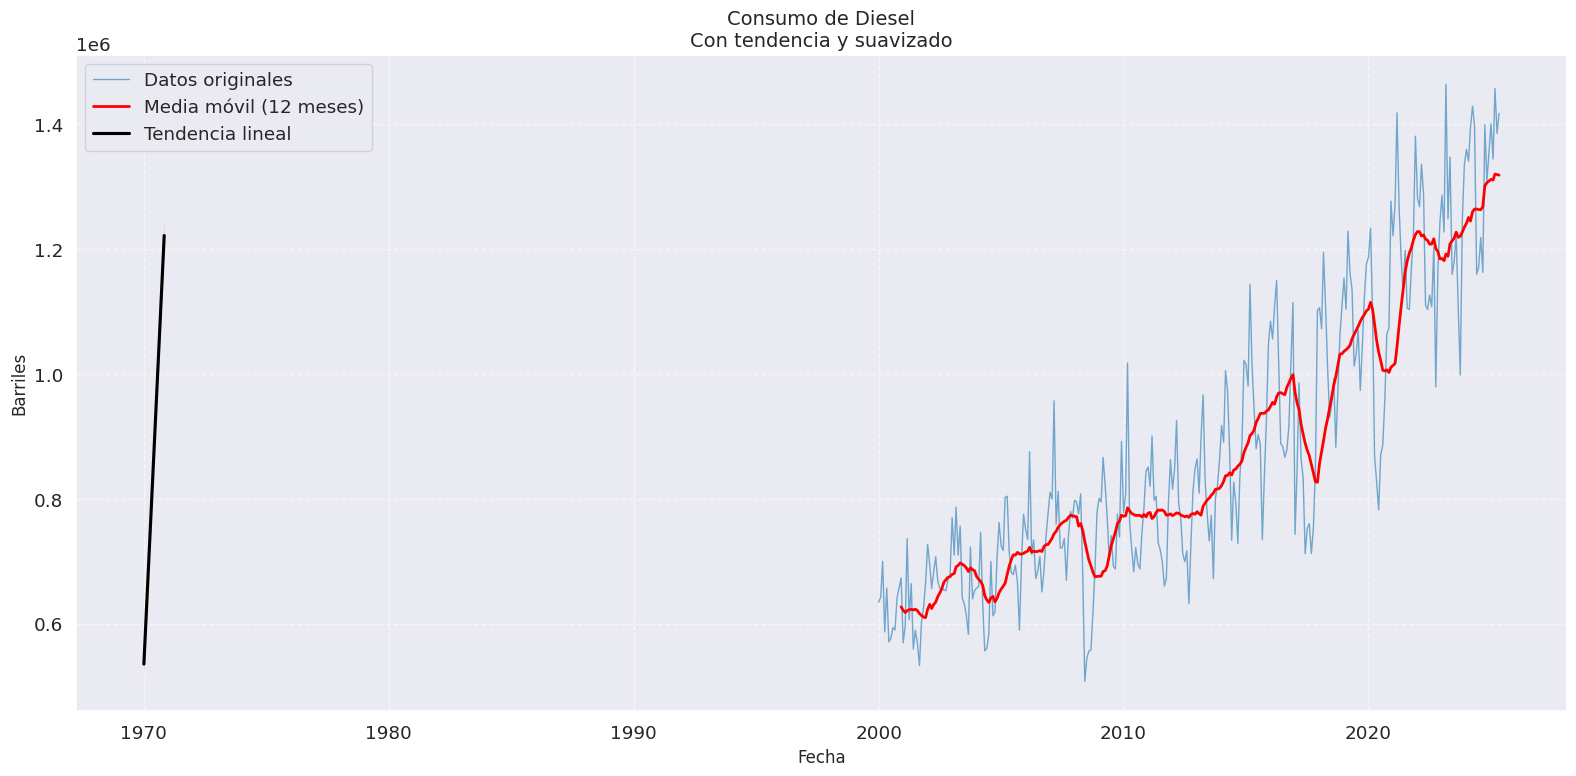

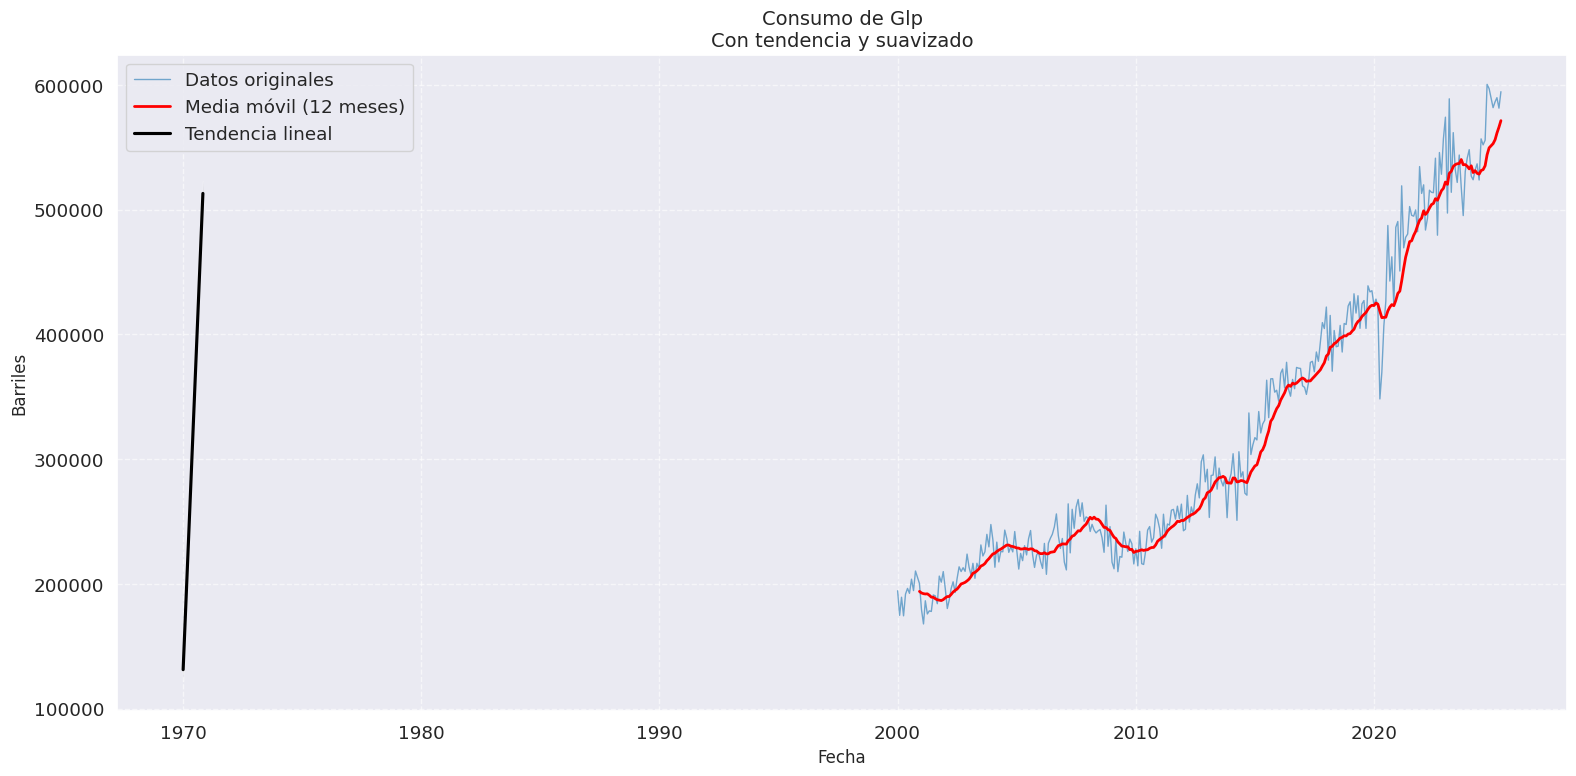

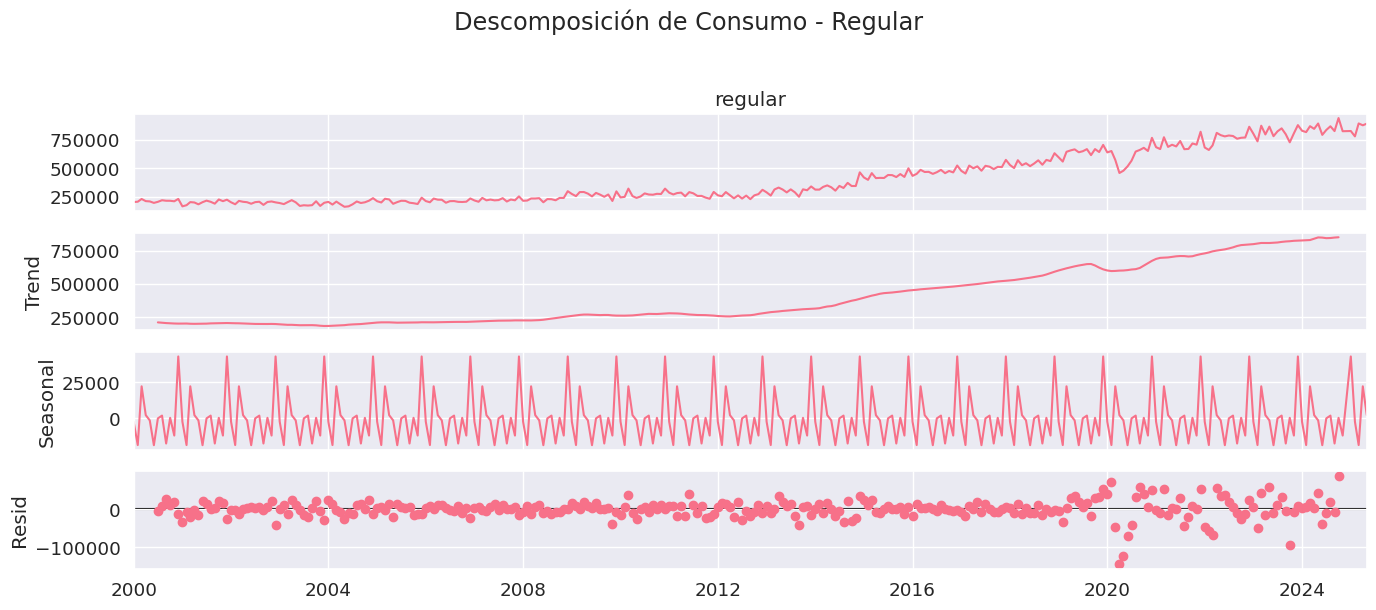

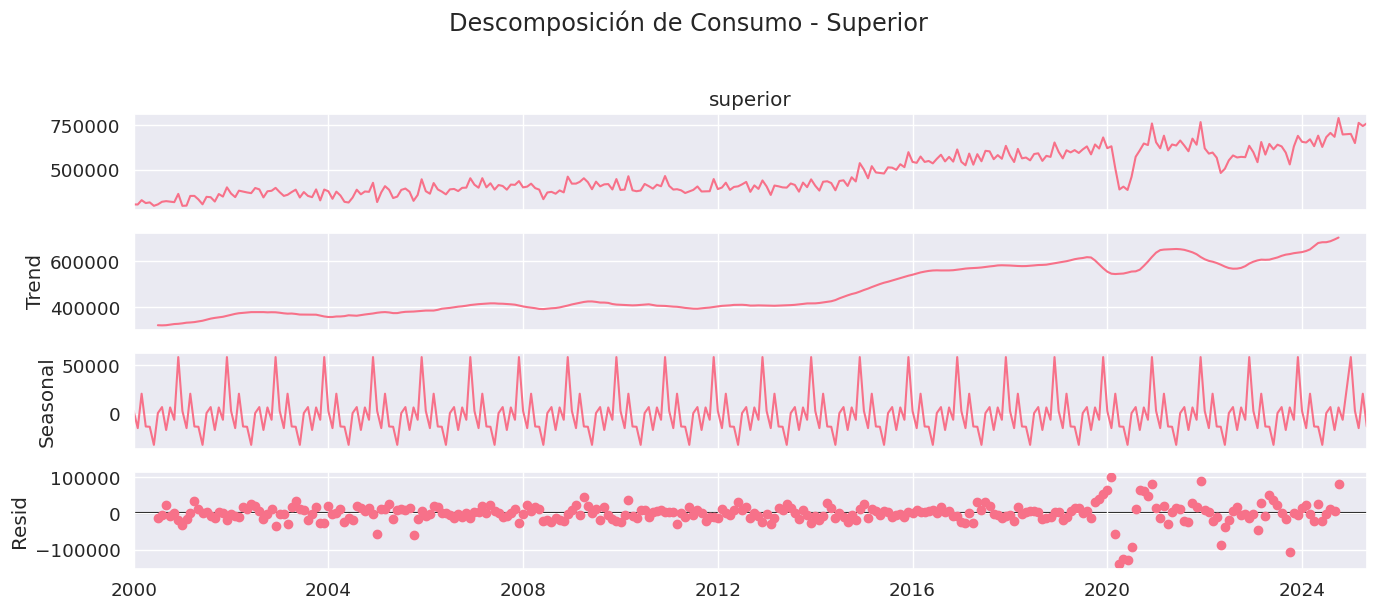

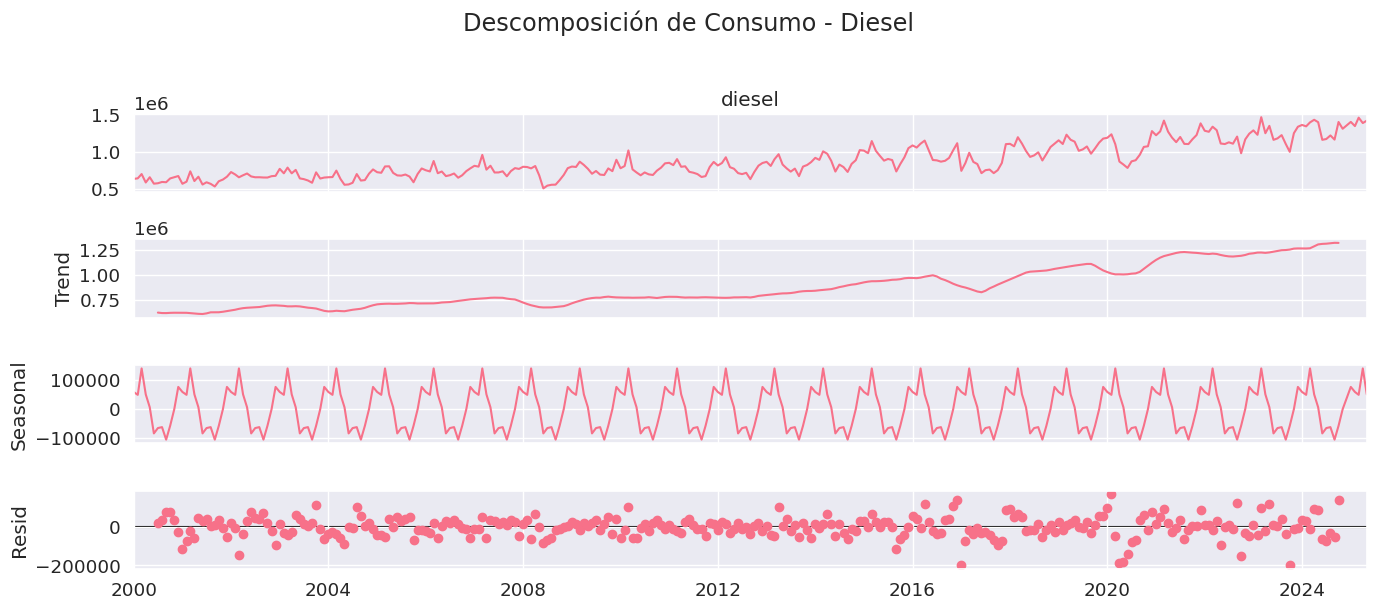

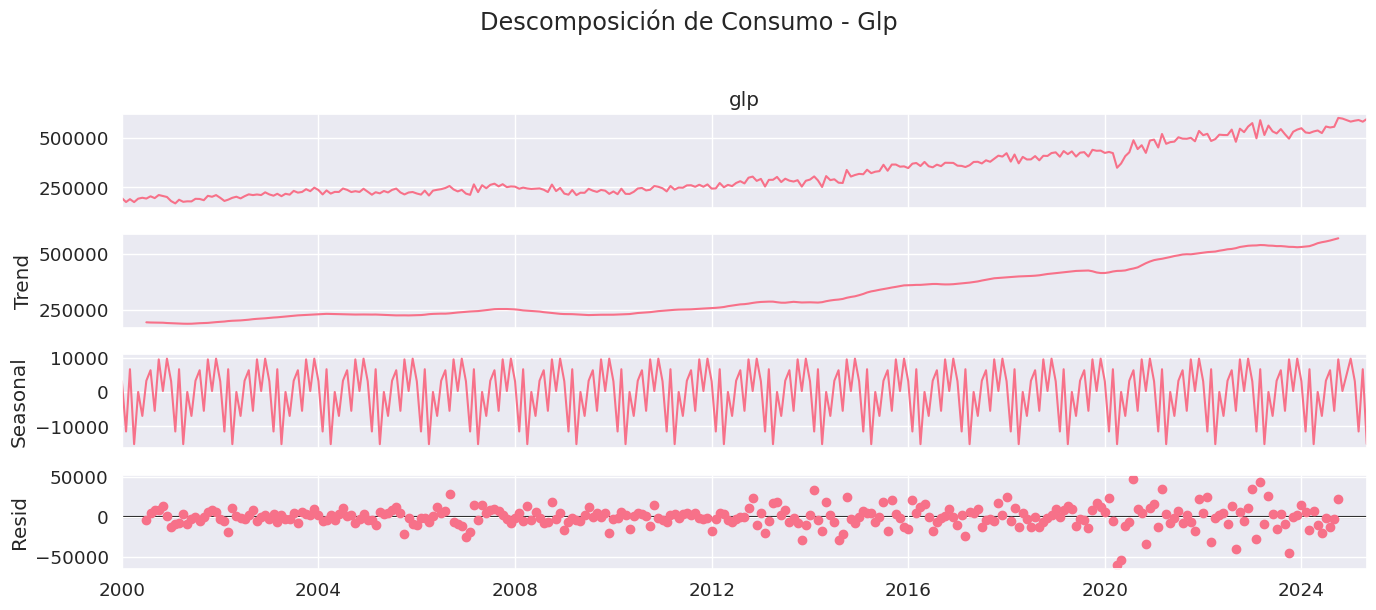


🔍 Test de Dickey-Fuller para regular:
Estadístico ADF: 2.5551
p-valor: 0.9991
Valores críticos:
   1%: -3.4532
   5%: -2.8716
   10%: -2.5721
Conclusión: No es estacionaria

🔍 Test de Dickey-Fuller para superior:
Estadístico ADF: 0.0759
p-valor: 0.9644
Valores críticos:
   1%: -3.4530
   5%: -2.8715
   10%: -2.5721
Conclusión: No es estacionaria

🔍 Test de Dickey-Fuller para diesel:
Estadístico ADF: 0.0458
p-valor: 0.9622
Valores críticos:
   1%: -3.4530
   5%: -2.8715
   10%: -2.5721
Conclusión: No es estacionaria

🔍 Test de Dickey-Fuller para glp:
Estadístico ADF: 1.5606
p-valor: 0.9977
Valores críticos:
   1%: -3.4526
   5%: -2.8713
   10%: -2.5720
Conclusión: No es estacionaria


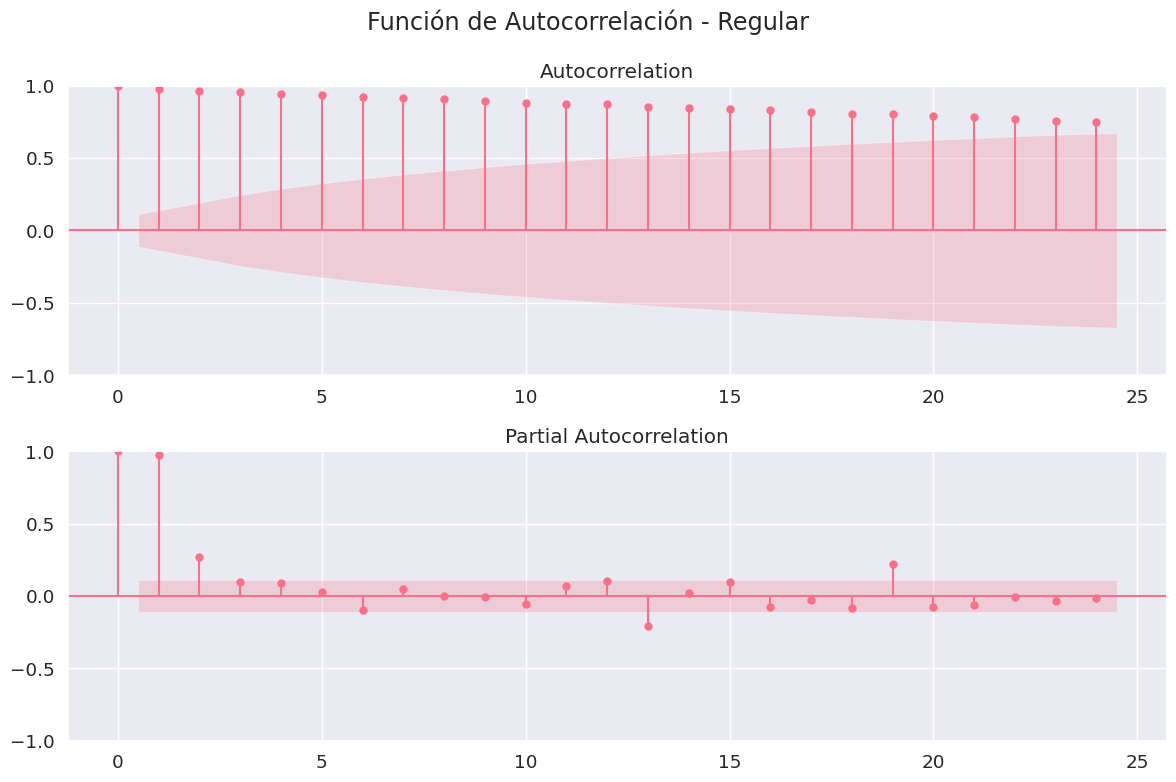

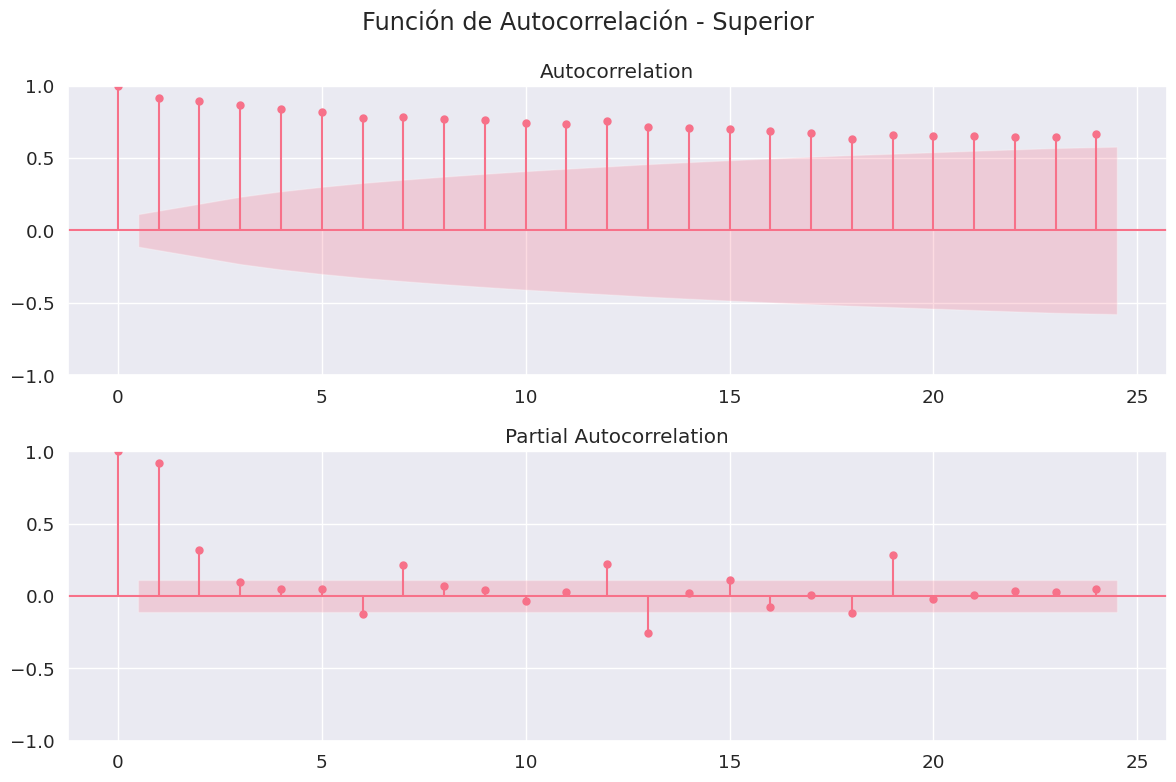

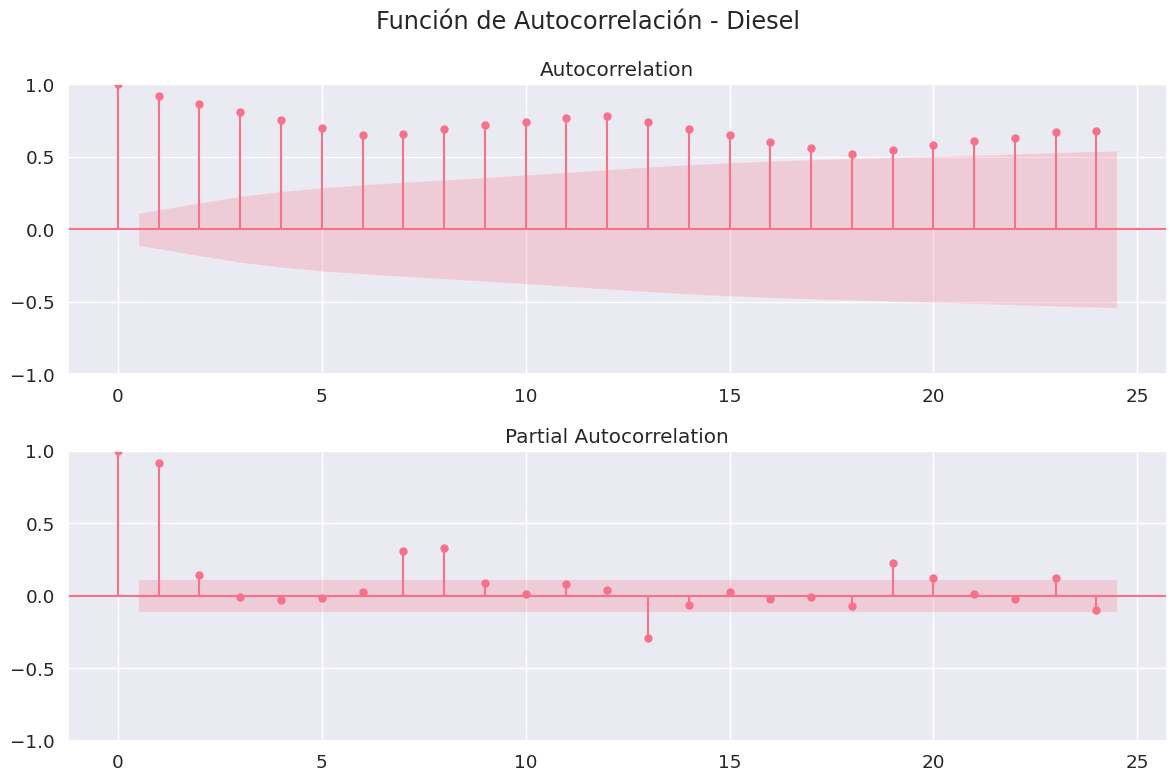

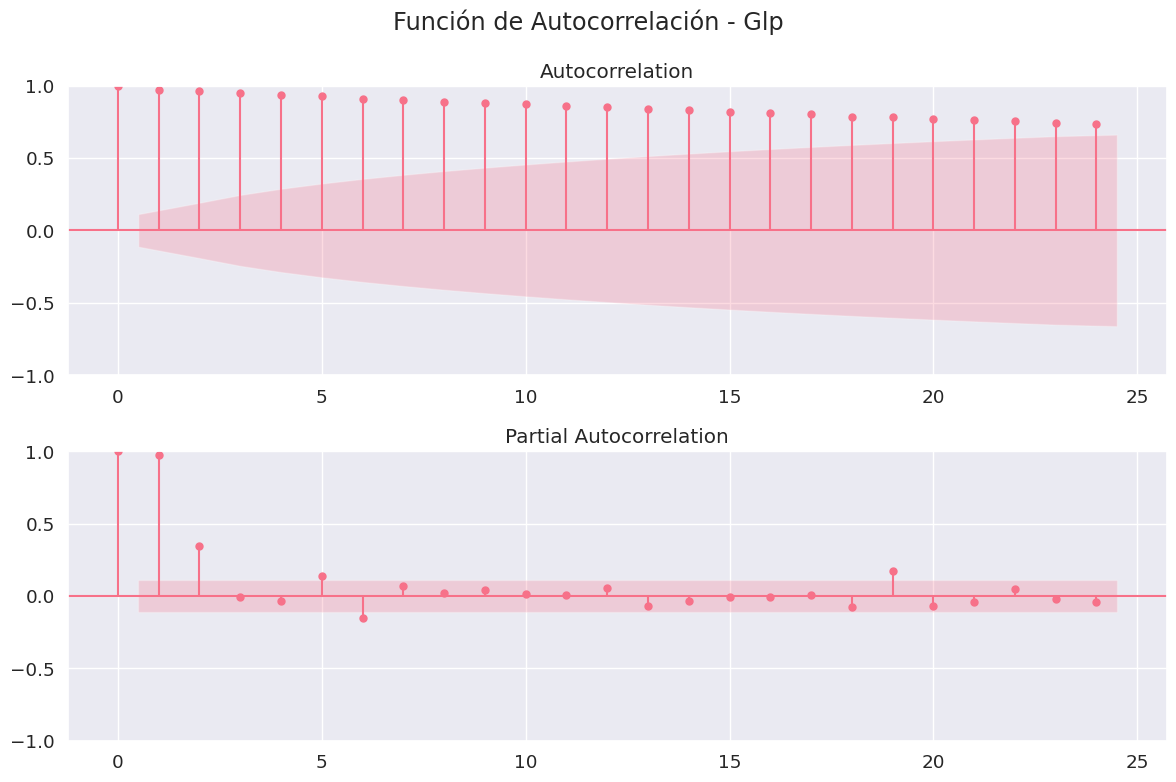


📌 COMPORTAMIENTO DURANTE PANDEMIA:
                regular       superior        diesel            glp
pandemia                                                           
False     397767.117263  482817.373558  8.812744e+05  406127.946173
True      669143.261250  626510.538750  1.104523e+06  602385.853750


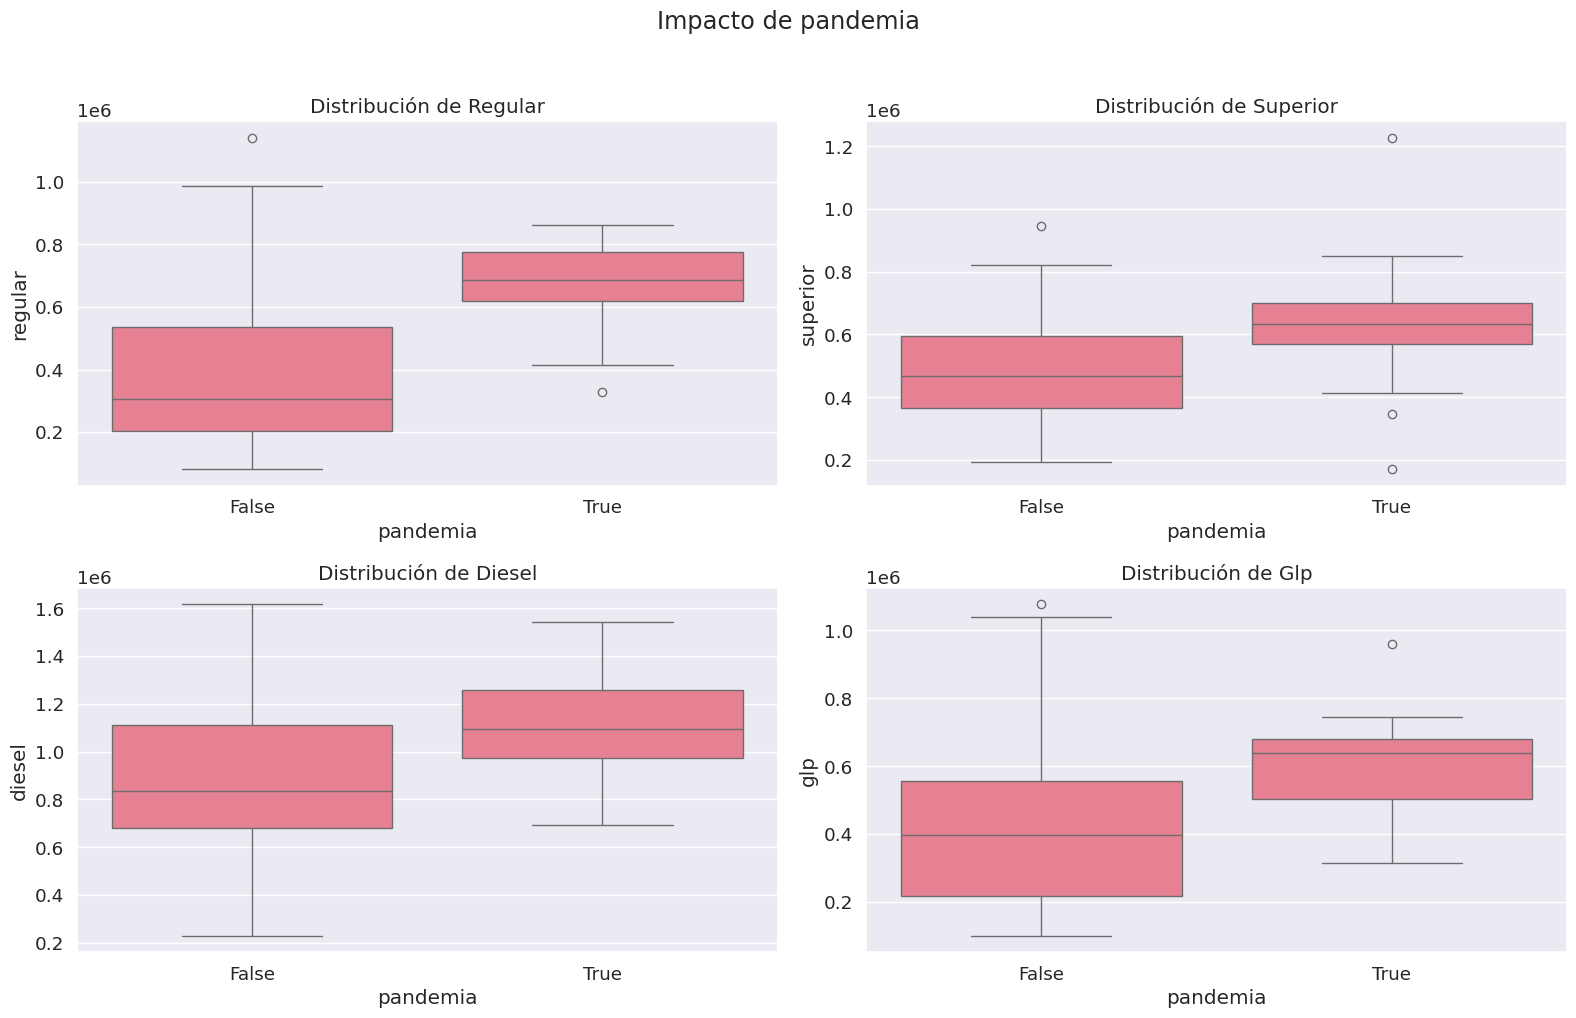


📌 COMPORTAMIENTO DURANTE GUERRA_UCRANIA:
                      regular       superior        diesel            glp
guerra_ucrania                                                           
False           352912.305809  469542.495504  8.385633e+05  382891.250019
True            832314.432927  648522.379268  1.274473e+06  663831.292824


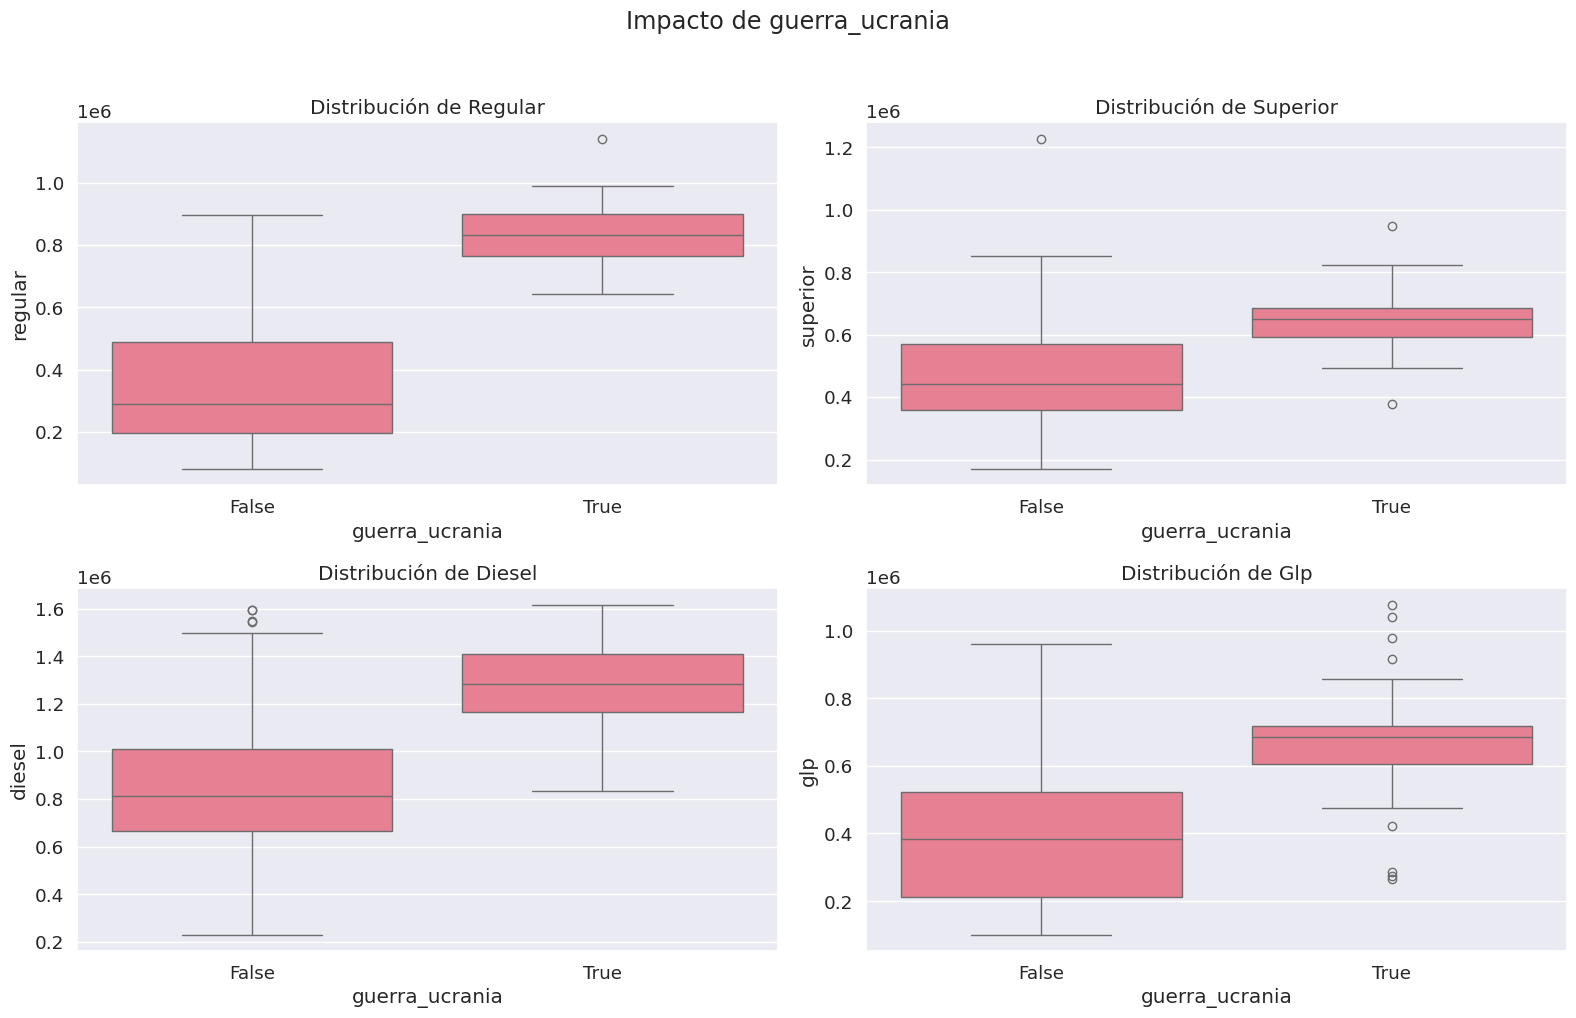


🔗 MATRIZ DE CORRELACIÓN (CONSUMO):


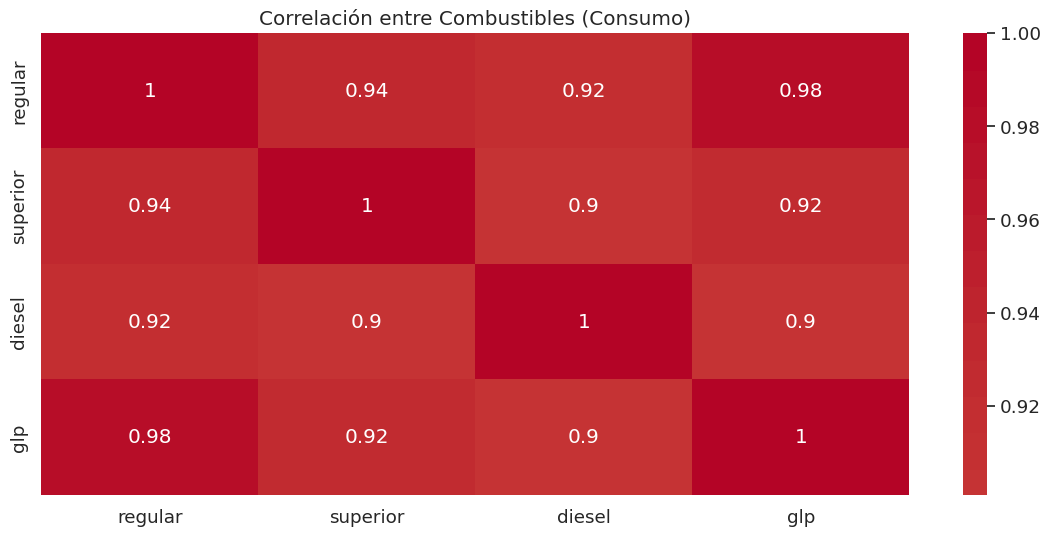

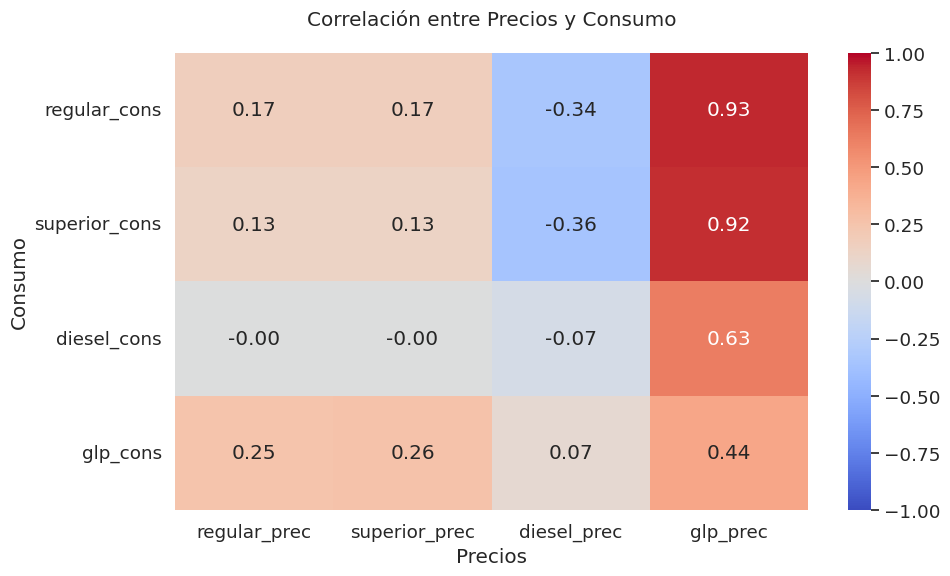


✅ ANÁLISIS COMPLETADO CON ÉXITO


In [47]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Configuración de visualización
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
pd.set_option('display.max_columns', None)


# 2. CARGA Y LIMPIEZA DE DATOS

def cargar_datos():

    consumo = pd.read_excel('./consumos/CONSUMO-HIDROCARBUROS-2024-2025.xlsx')
    importacion = pd.read_excel('./importacion/IMPORTACION-HIDROCARBUROS-VOLUMEN-2024-2025.xlsx')
    precios = pd.read_excel('./precios/Precios-Promedio-Nacionales-Diarios-2025.xlsx')


    for df in [consumo, importacion, precios]:
        df.columns = df.columns.str.strip().str.lower()


    rename_dict = {
        'gasolina regular': 'regular',
        'gasolina superior': 'superior',
        'diesel bajo azufre': 'diesel',
        'gas licuado de petróleo': 'glp'
    }

    consumo = consumo.rename(columns=rename_dict)
    importacion = importacion.rename(columns=rename_dict)
    precios = precios.rename(columns={'glp cilindro 25lbs.': 'glp'})


    for df in [consumo, importacion, precios]:
        df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
        df.dropna(subset=['fecha'], inplace=True)
        df.sort_values('fecha', inplace=True)


    columnas = ['fecha', 'regular', 'superior', 'diesel', 'glp']
    return consumo[columnas], importacion[columnas], precios[columnas]

consumo, importacion, precios = cargar_datos()


# 3. ANÁLISIS DESCRIPTIVO

print("\n📊 ESTADÍSTICOS DESCRIPTIVOS (CONSUMO):")
print(consumo.describe())

print("\n📊 ESTADÍSTICOS DESCRIPTIVOS (IMPORTACIÓN):")
print(importacion.describe())

print("\n📊 ESTADÍSTICOS DESCRIPTIVOS (PRECIOS):")
print(precios.describe())


# 4. VISUALIZACIÓN DE SERIES

def graficar_serie_completa(serie, titulo, ylabel, color):
    """Grafica la serie temporal con media móvil y tendencia"""
    plt.figure(figsize=(16, 8))


    plt.plot(serie, label='Datos originales', color=color, alpha=0.6, linewidth=1)


    rolmean = serie.rolling(window=12).mean()
    plt.plot(rolmean, label='Media móvil (12 meses)', color='red', linewidth=2)


    sns.regplot(x=np.arange(len(serie)), y=serie.values,
                scatter=False, label='Tendencia lineal', color='black')

    plt.title(f'{titulo}\nCon tendencia y suavizado', fontsize=14)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Aplicar a todas las series
for nombre, serie in consumo.set_index('fecha').items():
    graficar_serie_completa(serie, f'Consumo de {nombre.capitalize()}', 'Barriles', '#1f77b4')


# 5. DESCOMPOSICIÓN DE SERIES

def descomponer_serie(serie, tipo='consumo'):
    try:
        resultado = seasonal_decompose(serie.dropna(), model='additive', period=12)
        resultado.plot()
        plt.suptitle(f'Descomposición de {tipo} - {serie.name.capitalize()}', y=1.02)
        plt.tight_layout()
        plt.show()
    except ValueError as e:
        print(f"⚠️ Error en {serie.name}: {str(e)}")

# Aplicar a todas las series mensuales
for nombre, serie in consumo.set_index('fecha').items():
    descomponer_serie(serie, 'Consumo')


# 6. ANÁLISIS DE ESTACIONARIEDAD

def test_dickey_fuller(serie):
    print(f"\n🔍 Test de Dickey-Fuller para {serie.name}:")
    resultado = adfuller(serie.dropna())
    print(f'Estadístico ADF: {resultado[0]:.4f}')
    print(f'p-valor: {resultado[1]:.4f}')
    print('Valores críticos:')
    for key, value in resultado[4].items():
        print(f'   {key}: {value:.4f}')
    print(f"Conclusión: {'Es estacionaria' if resultado[1] < 0.05 else 'No es estacionaria'}")

# Aplicar test a las series
for nombre, serie in consumo.set_index('fecha').items():
    test_dickey_fuller(serie)


# 7. ANÁLISIS DE AUTOCORRELACIÓN

def graficar_acf_pacf(serie):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(serie.dropna(), lags=24, ax=ax1)
    plot_pacf(serie.dropna(), lags=24, ax=ax2)
    plt.suptitle(f'Función de Autocorrelación - {serie.name.capitalize()}')
    plt.tight_layout()
    plt.show()

for nombre, serie in consumo.set_index('fecha').items():
    graficar_acf_pacf(serie)


# 8. ANÁLISIS DE EVENTOS ESPECIALES

def analizar_eventos(df, evento_nombre, condicion):
    df[evento_nombre] = condicion
    print(f"\n📌 COMPORTAMIENTO DURANTE {evento_nombre.upper()}:")

    # Comparación estadística
    print(df.groupby(evento_nombre)[['regular', 'superior', 'diesel', 'glp']].mean())

    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    for ax, col in zip(axes.flat, ['regular', 'superior', 'diesel', 'glp']):
        sns.boxplot(data=df, x=evento_nombre, y=col, ax=ax)
        ax.set_title(f'Distribución de {col.capitalize()}')
    plt.suptitle(f'Impacto de {evento_nombre}', y=1.02)
    plt.tight_layout()
    plt.show()

# Configurar eventos
importacion['pandemia'] = importacion['fecha'].dt.year.between(2020, 2021)
importacion['guerra_ucrania'] = importacion['fecha'].dt.year >= 2022

analizar_eventos(importacion, 'pandemia', importacion['fecha'].dt.year.between(2020, 2021))
analizar_eventos(importacion, 'guerra_ucrania', importacion['fecha'].dt.year >= 2022)


# 9. ANÁLISIS DE CORRELACIONES

# Correlación entre combustibles
print("\n🔗 MATRIZ DE CORRELACIÓN (CONSUMO):")
corr_consumo = consumo.drop(columns='fecha').corr()
sns.heatmap(corr_consumo, annot=True, cmap='coolwarm', center=0)
plt.title('Correlación entre Combustibles (Consumo)')
plt.show()

# Correlación cruzada (Precios vs Consumo)
def analizar_correlacion_cruzada(consumo_df, precios_df):
    try:
        # Renombrar columnas para evitar conflictos
        consumo_renombrado = consumo_df.rename(columns={
            c: f"{c}_cons" for c in ['regular', 'superior', 'diesel', 'glp']
        })

        precios_renombrado = precios_df.rename(columns={
            c: f"{c}_prec" for c in ['regular', 'superior', 'diesel', 'glp']
        })

        # Unir los datos por fecha
        merged = pd.merge(consumo_renombrado, precios_renombrado, on='fecha', how='inner')

        if len(merged) == 0:
            print("⚠️ No hay fechas coincidentes entre consumo y precios")
            return

        # Columnas para correlación
        consumo_cols = [c for c in merged.columns if '_cons' in c]
        precios_cols = [c for c in merged.columns if '_prec' in c]

        if not consumo_cols or not precios_cols:
            print("⚠️ No se encontraron columnas válidas para correlación")
            return

        # Calcular matriz de correlación
        corr_matrix = merged[consumo_cols + precios_cols].corr()

        # Extraer solo las correlaciones cruzadas
        corr_cruzada = corr_matrix.loc[consumo_cols, precios_cols]

        # Visualización
        plt.figure(figsize=(10, 6))
        sns.heatmap(corr_cruzada, annot=True, cmap='coolwarm',
                   center=0, vmin=-1, vmax=1, fmt=".2f")
        plt.title('Correlación entre Precios y Consumo', pad=20)
        plt.xlabel('Precios')
        plt.ylabel('Consumo')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Error en correlación cruzada: {str(e)}")

analizar_correlacion_cruzada(consumo, precios)

# 10. EXPORTAR RESULTADOS

# Guardar datos procesados
consumo.to_csv('consumo_procesado.csv', index=False)
importacion.to_csv('importacion_procesada.csv', index=False)
precios.to_csv('precios_procesados.csv', index=False)

print("\n✅ ANÁLISIS COMPLETADO CON ÉXITO")

In [4]:
import pandas as pd

# Cargar el archivo Excel
file_path = ('./consumos/CONSUMO-HIDROCARBUROS-2024-2025.xlsx')
xls = pd.ExcelFile(file_path)


df = xls.parse('CONSUMO', skiprows=6)


df_gas = df[['Fecha', 'Gasolina regular', 'Gasolina superior']].copy()


df_gas = df_gas[pd.to_datetime(df_gas['Fecha'], errors='coerce').notna()]
df_gas['Fecha'] = pd.to_datetime(df_gas['Fecha'])

# Visualizar los primeros datos
df_gas.head()


,Fecha,Gasolina regular,Gasolina superior
0,2000-01-01,202645.20,308156.82
1,2000-02-01,205530.96,307766.31
2,2000-03-01,229499.56,331910.29
3,2000-04-01,210680.40,315648.08
4,2000-05-01,208164.34,319667.97


In [5]:

serie_regular = df_gas[['Fecha', 'Gasolina regular']].copy().set_index('Fecha')
serie_superior = df_gas[['Fecha', 'Gasolina superior']].copy().set_index('Fecha')


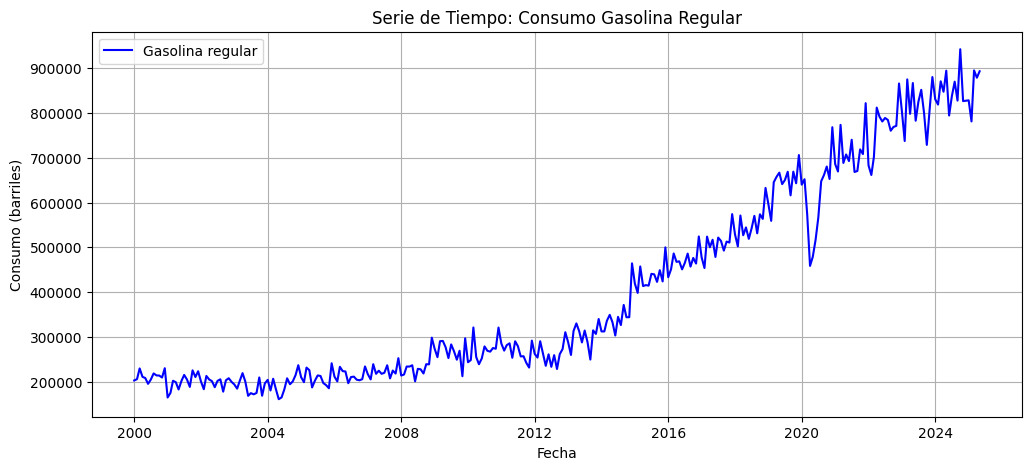

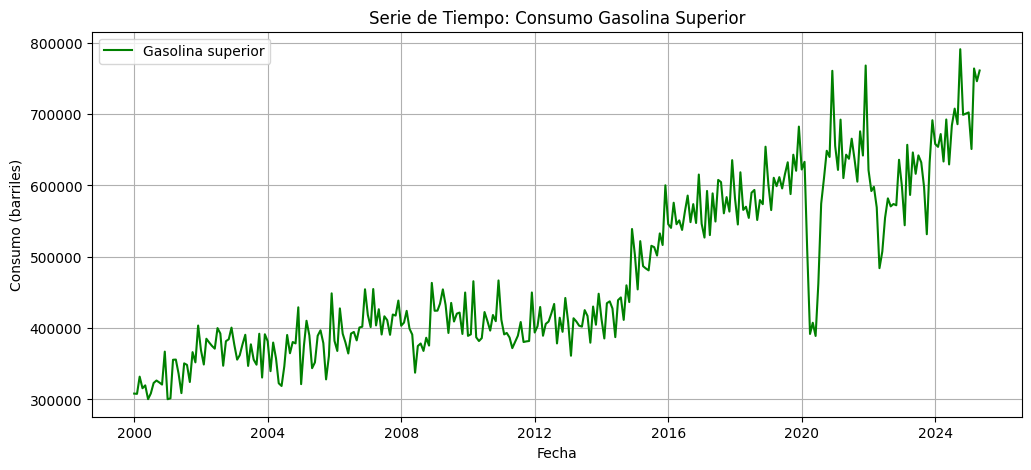

In [6]:
import matplotlib.pyplot as plt

# Graficar gasolina regular
plt.figure(figsize=(12, 5))
plt.plot(serie_regular, label='Gasolina regular', color='blue')
plt.title('Serie de Tiempo: Consumo Gasolina Regular')
plt.xlabel('Fecha')
plt.ylabel('Consumo (barriles)')
plt.grid(True)
plt.legend()
plt.show()

# Graficar gasolina superior
plt.figure(figsize=(12, 5))
plt.plot(serie_superior, label='Gasolina superior', color='green')
plt.title('Serie de Tiempo: Consumo Gasolina Superior')
plt.xlabel('Fecha')
plt.ylabel('Consumo (barriles)')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

# --- Regular ---
resultado_regular = adfuller(serie_regular['Gasolina regular'].dropna())
print("ADF - Gasolina regular")
print(f"Estadístico ADF: {resultado_regular[0]}")
print(f"p-value: {resultado_regular[1]}")
if resultado_regular[1] < 0.05:
    print(" La serie ES estacionaria en media.")
else:
    print("❌ La serie NO es estacionaria en media.")

# --- Superior ---
resultado_superior = adfuller(serie_superior['Gasolina superior'].dropna())
print("\nADF - Gasolina superior")
print(f"Estadístico ADF: {resultado_superior[0]}")
print(f"p-value: {resultado_superior[1]}")
if resultado_superior[1] < 0.05:
    print(" La serie ES estacionaria en media.")
else:
    print("❌ La serie NO es estacionaria en media.")


ADF - Gasolina regular
Estadístico ADF: 2.5550976170856887
p-value: 0.9990654906073354
❌ La serie NO es estacionaria en media.

ADF - Gasolina superior
Estadístico ADF: 0.07592641160886357
p-value: 0.964378519895292
❌ La serie NO es estacionaria en media.


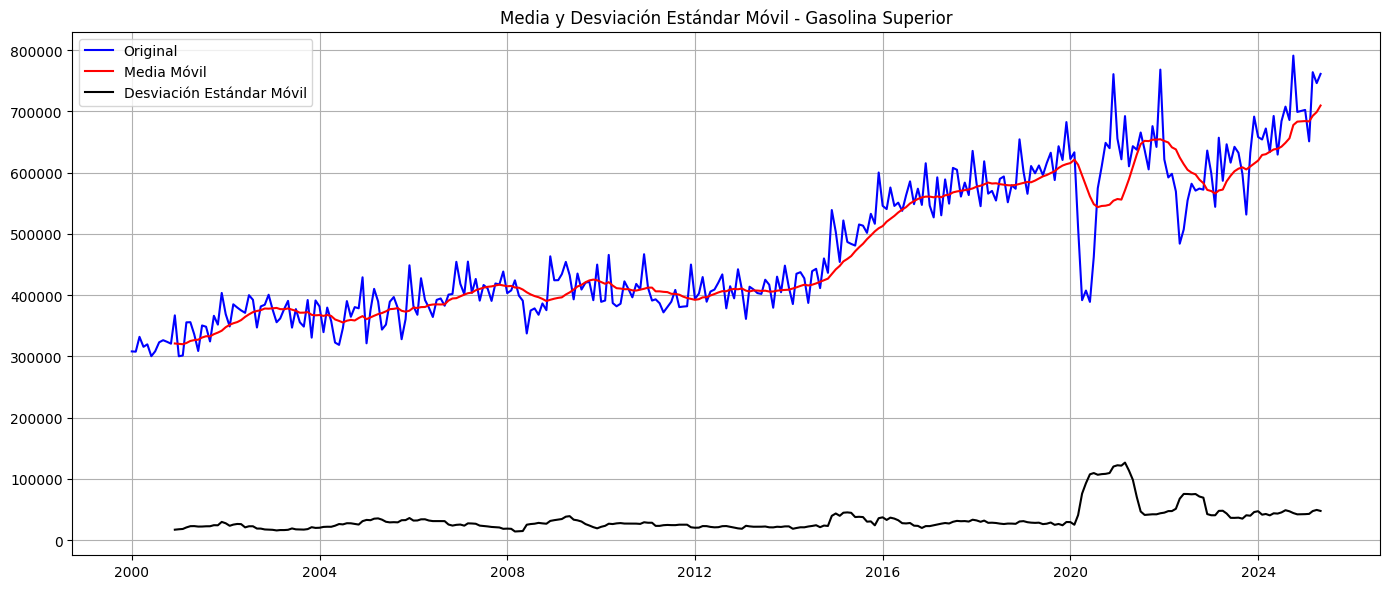

In [ ]:
# Calcular media móvil y desviación estándar móvil para Gasolina Superior
mediaMovil_superior = serie_superior['Gasolina superior'].rolling(window=12).mean()
desvMovil_superior = serie_superior['Gasolina superior'].rolling(window=12).std()

# Gráfico para Gasolina Superior
plt.figure(figsize=(14, 6))
plt.plot(serie_superior['Gasolina superior'], color='blue', label='Original')
plt.plot(mediaMovil_superior, color='red', label='Media Móvil')
plt.plot(desvMovil_superior, color='black', label='Desviación Estándar Móvil')
plt.title('Media y Desviación Estándar Móvil - Gasolina Superior')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


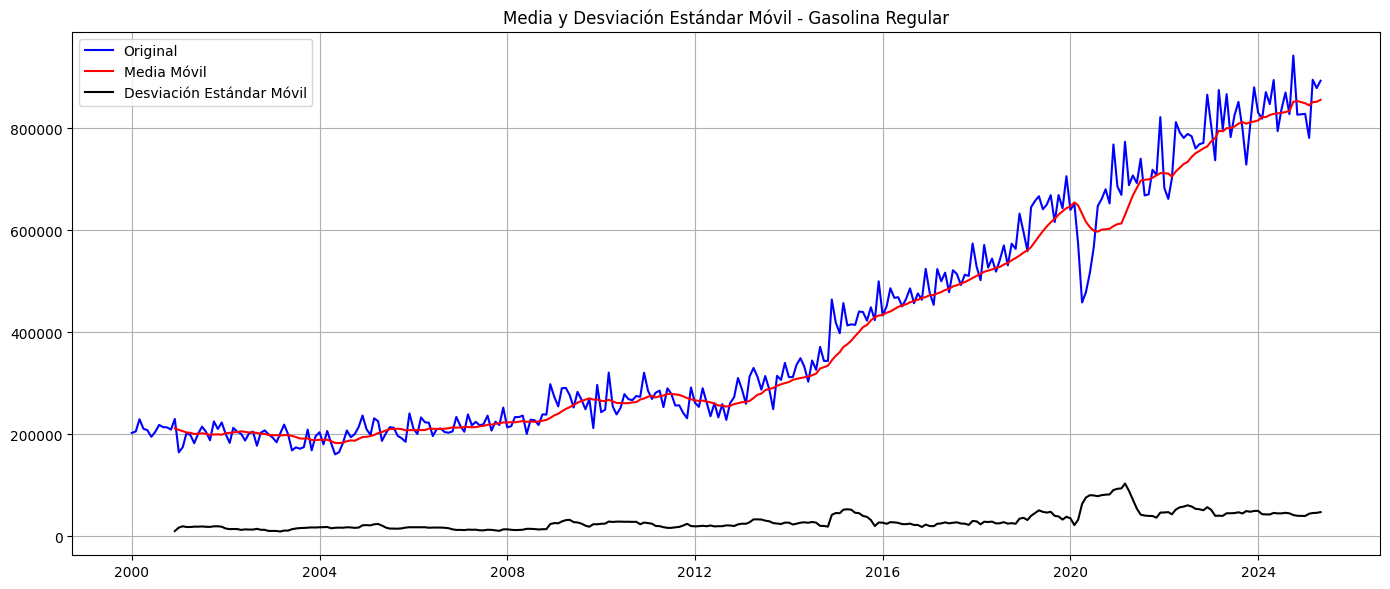

In [ ]:
# Calcular media móvil y desviación estándar móvil (ventana de 12 meses)
mediaMovil_regular = serie_regular['Gasolina regular'].rolling(window=12).mean()
desvMovil_regular = serie_regular['Gasolina regular'].rolling(window=12).std()

# Gráfico
plt.figure(figsize=(14, 6))
plt.plot(serie_regular['Gasolina regular'], color='blue', label='Original')
plt.plot(mediaMovil_regular, color='red', label='Media Móvil')
plt.plot(desvMovil_regular, color='black', label='Desviación Estándar Móvil')
plt.title('Media y Desviación Estándar Móvil - Gasolina Regular')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()
